In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from enum import Enum
from random import choice
import math
from copy import deepcopy
from matplotlib.pyplot import figure

In [2]:
class Options(Enum):
    # Primitive options
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3
    
    # Multi-step options
    OUT_11 = 4
    OUT_12 = 5
    OUT_21 = 6
    OUT_22 = 7
    OUT_31 = 8
    OUT_32 = 9
    OUT_41 = 10
    OUT_42 = 11
    

class Hallway:
    def __init__(self, start_position, goals):
        
        self._start_position = start_position
        self._goals = goals
        
        
        self.primitive_options = [Options.UP, Options.DOWN, Options.LEFT, Options.RIGHT]
        self.multistep_options = [Options.OUT_11,
                                   Options.OUT_12,
                                   Options.OUT_21,
                                   Options.OUT_22,
                                   Options.OUT_31,
                                   Options.OUT_32,
                                   Options.OUT_41,
                                   Options.OUT_42]

        self._all_options = self.primitive_options + self.multistep_options
        
        self._current_state = list(self._start_position)
        self._grid = self.__get_grid()
        self._states = self.__get_states()
        
        if self._start_position not in self._states:
            raise Exception('Invalid start position')
            
        for goal in self._goals:
            if goal not in self._states:
                raise Exception('Invalid goal')
        
    def reset(self):
        self._current_state = list(self._start_position)
        self._grid = self.__get_grid()
        self._states = self.__get_states()
        
        
    def step(self, option):
        
        if option in self.primitive_options:
            next_state, r = self.__primitive_step(option)
        else:
            r = 0
            next_state = self._current_state
        
        self._current_state = next_state
        return next_state, r
    
    def render(self):
        fig, ax = plt.subplots()
        ax.imshow(self._grid)

        # draw gridlines
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
        ax.set_xticks(np.arange(-0.5, 12, 1))
        ax.set_yticks(np.arange(-0.5, 12, 1))

        ax.set_yticklabels([])
        ax.set_xticklabels([])
        plt.show()
        
    def __primitive_step(self, option):
        real_option = option
        if np.random.random_sample() <= 1./3.:
            print('random!')
            real_option = choice([op for op in self.primitive_options if op != option])
                
        if real_option == Options.UP:
            new_state = (self._current_state[0] - 1, self._current_state[1])
        elif real_option == Options.DOWN:
            new_state = (self._current_state[0] + 1, self._current_state[1])
        elif real_option == Options.LEFT:
            new_state = (self._current_state[0], self._current_state[1] - 1)
        elif real_option == Options.RIGHT:
            new_state = (self._current_state[0], self._current_state[1] + 1)
        else:
            raise Exception('Invalid option called')
            
        
        if new_state in self._states:
            if new_state in self._goals:
                return new_state, +1
            else:
                return new_state, 0
            
        return self._current_state, 0
        
        
    def __get_states(self):
        states = set()
        for row in range(len(self._grid)):
            for column in range(len(self._grid[0])):
                if self._grid[row][column] > 0:
                    states.add((row,column))
        return states
    def __get_grid(self):
        return [
            [0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,1,1,1,1,1,0,1,1,1,1,1,0],
            [0,1,1,1,1,1,0,1,1,1,1,1,0],
            [0,1,1,1,1,1,2,1,1,1,1,1,0],
            [0,1,1,1,1,1,0,1,1,1,1,1,0],
            [0,1,1,1,1,1,0,1,1,1,1,1,0],
            [0,0,2,0,0,0,0,1,1,1,1,1,0],
            [0,1,1,1,1,1,0,0,0,2,0,0,0],
            [0,1,1,1,1,1,0,1,1,1,1,1,0],
            [0,1,1,1,1,1,0,1,1,1,1,1,0],
            [0,1,1,1,1,1,2,1,1,1,1,1,0],
            [0,1,1,1,1,1,0,1,1,1,1,1,0],
            [0,0,0,0,0,0,0,0,0,0,0,0,0]
        ]


In [3]:
def option_d(option):
    if option == Options.UP:
        return (-1,0)
    elif option == Options.DOWN:
        return (1,0)
    elif option == Options.LEFT:
        return (0,-1)
    elif option == Options.RIGHT:
        return (0,1)
    else:
        raise Exception('Error')

def get_prob_distro(states, actions, options):
    all_options = actions + options
    probs = {state:{ option: {} for option in all_options }  for state in states}

    for s in states:
        for o in all_options:
            if o in actions:
                d = option_d(o)
                next_state = (s[0] + d[0], s[1] + d[1])

                if next_state not in states:
                    next_state = s

                probs[s][o] = {
                    next_state: 2./3.
                }

                for a in ((-1,0), (1,0), (0,-1), (0,1)):
                    if a == d:
                        continue

                    next_state = (s[0] + a[0], s[1] + a[1])

                    if next_state not in states:
                        next_state = s

                    if next_state in probs[s][o].keys():
                        probs[s][o][next_state] += 1./9.
                    else:
                        probs[s][o][next_state] = 1./9.
            else:
                # first room
                if s[0] >= 7 and s[0] <= 11 and s[1] >= 1 and s[1] <= 5:
                    if o == Options.OUT_11:
                        probs[s][o][(6,2)] = 1.
                    elif o == Options.OUT_12:
                        probs[s][o][(10,6)] = 1.
                    else:
                        del probs[s][o]

                # second room
                if s[0] >= 1 and s[0] <= 5 and s[1] >= 1 and s[1] <= 5:
                    if o == Options.OUT_21:
                        probs[s][o][(6,2)] = 1.
                    elif o == Options.OUT_22:
                        probs[s][o][(3,6)] = 1.
                    else:
                        del probs[s][o]

                # third room
                if s[0] >= 1 and s[0] <= 6 and s[1] >= 7 and s[1] <= 11:
                    if o == Options.OUT_31:
                        probs[s][o][(3,6)] = 1.
                    elif o == Options.OUT_32:
                        probs[s][o][(7,9)] = 1.
                    else:
                        del probs[s][o]

                # fourth room
                if s[0] >= 8 and s[0] <= 11 and s[1] >= 7 and s[1] <= 11:
                    if o == Options.OUT_41:
                        probs[s][o][(7,9)] = 1.
                    elif o == Options.OUT_42:
                        probs[s][o][(10,6)] = 1.
                    else:
                        del probs[s][o]
    for hallway in ((3,6),(10,6),(7,9),(6,2)):
        for o in options:
            del probs[hallway][o]
    # hallway probs
    probs[(3,6)][Options.OUT_32] = {(7,9): 1.}
    probs[(3,6)][Options.OUT_11] = {(6,2): 1.}
    
    probs[(10,6)][Options.OUT_41] = {(7,9): 1.}
    probs[(10,6)][Options.OUT_12] = {(6,2): 1.}
    
    probs[(7,9)][Options.OUT_42] = {(10,6): 1.}
    probs[(7,9)][Options.OUT_31] = {(3,6): 1.}    
    
    probs[(6,2)][Options.OUT_12] = {(10,6): 1.}
    probs[(6,2)][Options.OUT_22] = {(3,6): 1.}   


    for state in probs.keys():
        for action in probs[state].keys():
            prob_distr_sum = sum(probs[state][action].values())
            assert  prob_distr_sum > .999999 and prob_distr_sum < 1.000000001

    return probs

In [4]:
def value_iteration(options_to_iterate='all', goal=(9,9)):

    hall = Hallway((1,1), [goal])
    
    if options_to_iterate == 'all':
        search_space = hall.primitive_options + hall.multistep_options
    elif options_to_iterate == 'primitive-only':
        search_space = hall.primitive_options
    elif options_to_iterate == 'multistep-only':
        search_space = hall.multistep_options
    else:
        raise Exception('Please use on of "all", "primitive-only", "multistep-only"')

    V = { s: 0.0 for s in hall._states }
    V[goal] = 1.0

    theta = 0.01
    p = get_prob_distro(hall._states, hall.primitive_options, hall.multistep_options)
    # Value Iteration
    Lambda = 1

    all_V= []
    #for _ in range(10):
    while Lambda > theta:
        Lambda = 0
        V_copy = deepcopy(V)
        for s in hall._states:
            v = V[s]

            maxo = -math.inf
            for o in p[s].keys():
                if o in search_space:
                    for s_next, po_s_s_next in p[s][o].items():
                        r = 1.0 if s == goal else 0.0
                        k = np.abs(s_next[0] - s[0]) + np.abs(s_next[1] - s[1])
                        o_v = po_s_s_next * (r  + (0.9 ** k) * V[s_next])
                        if o_v > maxo:
                            maxo = o_v
            if maxo != -math.inf:
                V_copy[s] = maxo
            Lambda = max(Lambda, np.abs(v - V_copy[s]))
        all_V.append(deepcopy(V))
        V = V_copy

    return all_V

In [5]:
vs_primitive = value_iteration('primitive-only', (7,9))
vs_multistep = value_iteration('multistep-only', (7,9))
vs_all = value_iteration()

In [6]:
def render_V(ax, V, title, factor=4):
    grid = [
        [0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,1,1,1,1,1,0,1,1,1,1,1,0],
        [0,1,1,1,1,1,0,1,1,1,1,1,0],
        [0,1,1,1,1,1,1,1,1,1,1,1,0],
        [0,1,1,1,1,1,0,1,1,1,1,1,0],
        [0,1,1,1,1,1,0,1,1,1,1,1,0],
        [0,0,1,0,0,0,0,1,1,1,1,1,0],
        [0,1,1,1,1,1,0,0,0,1,0,0,0],
        [0,1,1,1,1,1,0,1,1,1,1,1,0],
        [0,1,1,1,1,1,0,1,1,1,1,1,0],
        [0,1,1,1,1,1,1,1,1,1,1,1,0],
        [0,1,1,1,1,1,0,1,1,1,1,1,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0]
    ]
    
    for v in V:
        grid[v[0]][v[1]] += factor * V[v]
    
    ax.imshow(grid)

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-0.5, 12, 1))
    ax.set_yticks(np.arange(-0.5, 12, 1))

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
    
    ax.set_title(title)
    
    ax.plot()
    #plt.show()

<Figure size 120000x80000 with 0 Axes>

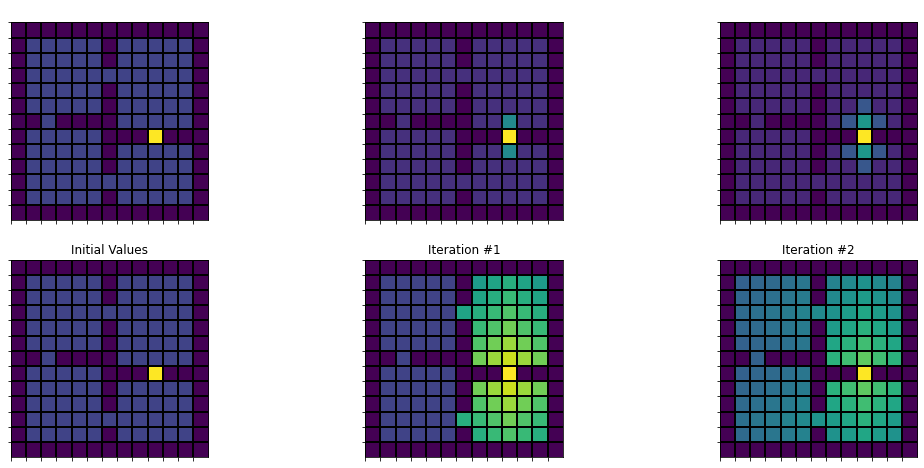

In [7]:
%matplotlib inline

figure(figsize=(120, 80), dpi=1000)
fig, axs = plt.subplots(2,3, figsize=(18,8 ))


render_V(axs[0,0], vs_primitive[0], ' ')
render_V(axs[0,1], vs_primitive[1], ' ')
render_V(axs[0,2], vs_primitive[2], ' ')

render_V(axs[1,0], vs_multistep[0], 'Initial Values')
render_V(axs[1,1], vs_multistep[1], 'Iteration #1')
render_V(axs[1,2], vs_multistep[2], 'Iteration #2')

plt.show()

<Figure size 120000x80000 with 0 Axes>

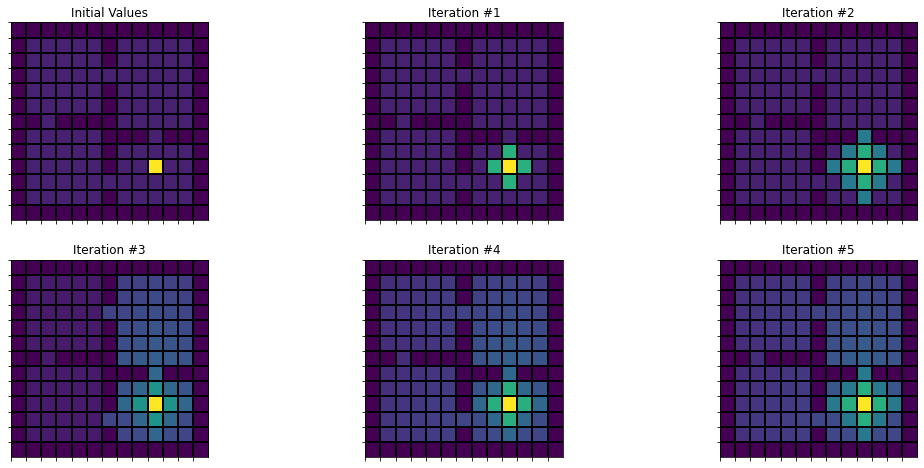

In [8]:
%matplotlib inline

figure(figsize=(120, 80), dpi=1000)
fig, axs = plt.subplots(2,3, figsize=(18,8 ))


render_V(axs[0,0], vs_all[0], 'Initial Values', factor=10)
render_V(axs[0,1], vs_all[1], 'Iteration #1', factor=10)
render_V(axs[0,2], vs_all[2], 'Iteration #2', factor=10)

render_V(axs[1,0], vs_all[3], 'Iteration #3', factor=10)
render_V(axs[1,1], vs_all[4], 'Iteration #4', factor=10)
render_V(axs[1,2], vs_all[5], 'Iteration #5', factor=10)

plt.show()